In [1]:
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt

# 데이터 로딩

In [3]:
trainset_raw = torchvision.datasets.MNIST(root='./data', train=True, download=True)
testset_raw = torchvision.datasets.MNIST(root='./data', train=False, download=True)

In [4]:
for row in trainset_raw.data[0].numpy():
    print(" ".join(f"{v:3}" for v in row))

  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255 247 127   0   0   0   0
  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0
  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82  82  56  39   0   0   0   0   0
  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 182 247 241   0   0   0   0   0   0   0   0 

In [5]:
# numpy → tensor 변환 & 정규화
def preprocess_mnist(dataset):
    images = dataset.data.float() / 255.0  # [0,255] → [0,1]
    mean, std = images.mean() , images.std()
    # images = (images - mean) / std         # Normalize
    labels = dataset.targets
    return images, labels

In [6]:
train_images, train_labels = preprocess_mnist(trainset_raw)
test_images, test_labels = preprocess_mnist(testset_raw)

In [7]:
# Dataset 객체로 묶기
full_dataset = torch.utils.data.TensorDataset(train_images, train_labels)

In [8]:
# train/val split (Dataset을 그대로 분할)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

In [9]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

# 모델 생성

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

In [11]:
model = DNN().to(device)  # 모델을 GPU로 이동
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습

In [12]:
train_losses, val_losses, val_accuracies = [], [], []

In [13]:
for epoch in range(20):
    model.train()
    running_loss = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(trainloader))

    # ----- Validation -----
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(valloader))
    val_accuracies.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/20], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

Epoch [1/5], Train Loss: 0.3114, Val Loss: 0.1544, Val Acc: 95.43%
Epoch [2/5], Train Loss: 0.1209, Val Loss: 0.1173, Val Acc: 96.55%
Epoch [3/5], Train Loss: 0.0793, Val Loss: 0.1072, Val Acc: 96.86%
Epoch [4/5], Train Loss: 0.0562, Val Loss: 0.0943, Val Acc: 97.10%
Epoch [5/5], Train Loss: 0.0419, Val Loss: 0.0890, Val Acc: 97.53%
Epoch [6/5], Train Loss: 0.0333, Val Loss: 0.0998, Val Acc: 97.52%
Epoch [7/5], Train Loss: 0.0243, Val Loss: 0.0978, Val Acc: 97.65%
Epoch [8/5], Train Loss: 0.0219, Val Loss: 0.1022, Val Acc: 97.61%
Epoch [9/5], Train Loss: 0.0177, Val Loss: 0.1071, Val Acc: 97.63%
Epoch [10/5], Train Loss: 0.0138, Val Loss: 0.1183, Val Acc: 97.38%
Epoch [11/5], Train Loss: 0.0160, Val Loss: 0.1188, Val Acc: 97.47%
Epoch [12/5], Train Loss: 0.0138, Val Loss: 0.1191, Val Acc: 97.57%
Epoch [13/5], Train Loss: 0.0109, Val Loss: 0.1127, Val Acc: 97.76%
Epoch [14/5], Train Loss: 0.0100, Val Loss: 0.1129, Val Acc: 97.92%
Epoch [15/5], Train Loss: 0.0129, Val Loss: 0.1226, Val A

# 학습결과 확인

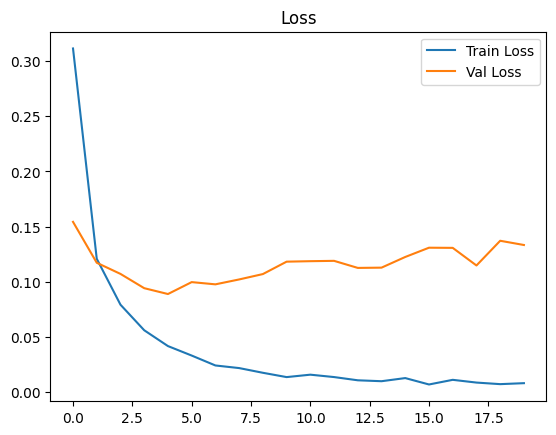

In [14]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()

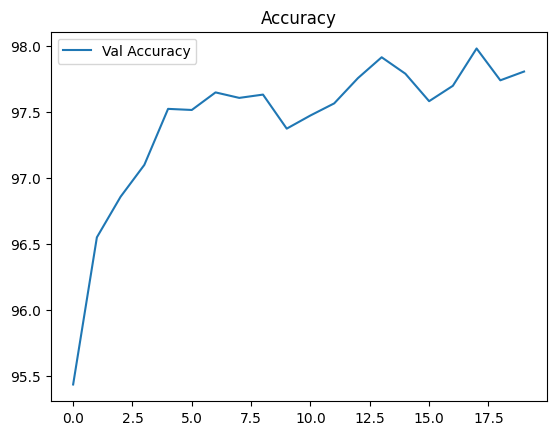

In [15]:
plt.figure()
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()